In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DataSet():
    def __init__(self,PATH,dataAugmentation = False):
        self.X = []
        self.Y = []
        self.PATH = PATH
        self.df = pd.read_csv(PATH+'driving_log.csv',names = ['Center', 'Left', 'Right', 's_c','s_l','s_r','speed'])
        self.IMAGE_PATH = PATH+'IMG/'
        self.dA = dataAugmentation
        self.set_dataSet()
    
    def get_ListOfImages(self, side, flip = False):
        images = []
        for path in self.df[side]:
            current_path = self.IMAGE_PATH + path.split('/')[-1]
            image = cv2.imread(current_path)
            if flip == True:
                image = cv2.flip( image, 0 )
            images.append(image)
        return images

    def get_steerings(self,side, correction):
        return np.array(self.df[side], dtype ='float32')+correction
    
    def get_X(self):
        print('Loading Images..... ')
        images_center = self.get_ListOfImages('Center')
        images_left   = self.get_ListOfImages('Left')
        images_right  = self.get_ListOfImages('Right')
        if self.dA == True:
            image_dA = self.get_ListOfImages('Center', flip = True)
            self.X = np.array(images_center+images_left+images_right+image_dA)
        else:
            self.X = np.array(images_center+images_left+images_right)
        print('Images loaded')

    def get_Y(self):
        steering_center = self.get_steerings('s_c',0)
        steering_left   = self.get_steerings('s_c',0.1)
        steering_right  = self.get_steerings('s_c',-0.1)
        if self.dA == True:
            steering_dA = self.get_steerings('s_c',0)*(-1)
            self.Y = np.concatenate([steering_center,steering_left,steering_right,steering_dA])
        else:
            self.Y = np.concatenate([steering_center,steering_left,steering_right])

    def set_dataSet(self):
        self.get_X()
        self.get_Y()
        print('Shape of X_train: {}, y_train: {} '.format(self.X.shape,self.Y.shape))

In [3]:
#Test Class from a normal drving
normal_driving = DataSet('../data_sim/', 1)

Loading Images..... 
Images loaded
Shape of X_train: (15164, 160, 320, 3), y_train: (15164,) 


In [4]:
#Test Class from a counter wise drving
counterwise_driving = DataSet('../data_sim_back/')

Loading Images..... 
Images loaded
Shape of X_train: (5772, 160, 320, 3), y_train: (5772,) 


In [5]:
#Test Class from a different recovering scenarios
recovering_driving = DataSet('../data_recover/',1)

Loading Images..... 
Images loaded
Shape of X_train: (9396, 160, 320, 3), y_train: (9396,) 


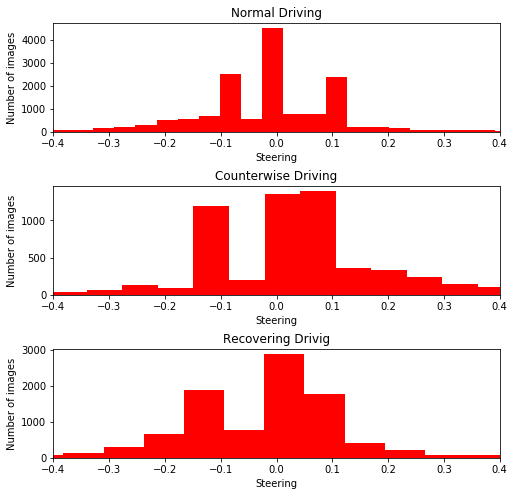

In [6]:
#Data_set
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8))

plt.subplots_adjust(hspace=0.5)

plt.subplot(3,1,1)
plt.hist(normal_driving.Y, bins=50,color=[1,0,0])
plt.title('Normal Driving')
plt.xlabel('Steering')
plt.ylabel('Number of images')
plt.xlim([-0.4,0.4])

plt.subplot(3,1,2)
plt.hist(counterwise_driving.Y, bins=20,color=[1,0,0])
plt.title('Counterwise Driving')
plt.xlabel('Steering')
plt.ylabel('Number of images')
plt.xlim([-0.4,0.4])

plt.subplot(3,1,3)
plt.hist(recovering_driving.Y, bins=20,color=[1,0,0])
plt.title('Recovering Drivig')
plt.xlabel('Steering')
plt.ylabel('Number of images')
plt.xlim([-0.4,0.4])

plt.show()

In [7]:
#Merge the 3 datasets
X_train = np.concatenate([normal_driving.X,counterwise_driving.X,recovering_driving.X])
y_train = np.concatenate([normal_driving.Y,counterwise_driving.Y,recovering_driving.Y])

(-0.4, 0.4)

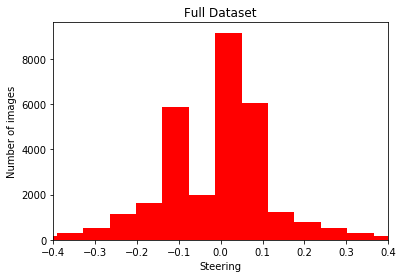

In [8]:
plt.hist(y_train, bins=30,color=[1,0,0])
plt.title('Full Dataset')
plt.xlabel('Steering')
plt.ylabel('Number of images')
plt.xlim([-0.4,0.4])

In [9]:
X_train.shape

(30332, 160, 320, 3)

In [ ]:
# Setup Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Cropping2D, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [ ]:
batch_size = 100
epochs = 15
pool_size = (2, 2)
input_shape = X_train.shape[1:]

model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))

# Convolutional Layer 1 and Dropout
model.add(Conv2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Conv Layer 2
model.add(Conv2D(32, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))

# Conv Layer 3
model.add(Conv2D(16, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))

# Conv Layer 4
model.add(Conv2D(8, 3, 3, border_mode='valid', subsample=(1,1)))
model.add(Activation('relu'))

# Pooling
model.add(MaxPooling2D(pool_size=pool_size))

# Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.5))

# Fully Connected Layer 1 and Dropout
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# FC Layer 2
model.add(Dense(64))
model.add(Activation('relu'))

# FC Layer 3
model.add(Dense(32))
model.add(Activation('relu'))

# Final FC Layer - just one output - steering angle
model.add(Dense(1))

# Compiling and training the model
#model.compile(metrics=['mean_squared_error'], optimizer='Nadam', loss='mean_squared_error')
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, verbose=2, validation_data=(X_val, y_val))


In [ ]:
# Build Convolutional Pooling Neural Network with Dropout in Keras Here
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
#Preprocess
model.add(Conv2D(12, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(1))
          
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

model.save('model.h5')